Brian Blaylock  
January 23, 2018

# OSG yearly stats for an area

In [1]:
%matplotlib inline

import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_data.grid_manager import pluck_point_new

plt.style.use('seaborn-notebook')

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 300

### Get area from the data grid

In [2]:
def get_area_MP(inputs):
    """
    Function for MultiProcessing:
    Return the values from an area in the HDF5 file array
    """
    FILE, STAT, xy, thresh = inputs
    try:
        with h5py.File(FILE, 'r') as f:
            #return np.max(f[STAT][:][xy])                # Return basic stat of area
            return np.sum(f[STAT][:][xy]>thresh)/float(np.size(f[STAT][:][xy])) # Return percent of area greater than a threshold
    except:
        #print "COULD NOT GET", FILE
        return np.nan

In [3]:
def get_area(FILE, STAT):
    """
    Return the values from an area in the HDF5 file array
    """
    with h5py.File(FILE, 'r') as f:
        return f[STAT][:]

### Get lat/lon grid from file for plotting

In [4]:
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

In [5]:
# Percentile Variable and Statistic of interest
var = 'UVGRD:80 m'
variable = var.replace(':', '_').replace(' ', '_')
stat = 'p95'

thresh = 10

# Domain center and area
cLAT = 37.718
cLON = -112.837

# Find gridpoint
x,y = pluck_point_new(cLAT, cLON, lat, lon)
x = x[0]
y = y[0]

# Area grid points
# 1) Define a gridpoint buffer
b = 10

# 2) get the xy corrdinates for the area. Index with the variable like so... lon[xy], lat[xy], data[xy], etc.
xy = np.meshgrid(range(x-b,x+b+1), range(y-b,y+b+1))


DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

In [6]:
# Plot a map of the area of interest
bot_left_lat  = np.min(lat[xy])
bot_left_lon  = np.min(lon[xy])
top_right_lat = np.max(lat[xy])
top_right_lon = np.max(lon[xy])

m = Basemap(resolution='i', projection='cyl', area_thresh=1500,\
        llcrnrlon=bot_left_lon, llcrnrlat=bot_left_lat, \
        urcrnrlon=top_right_lon, urcrnrlat=top_right_lat)

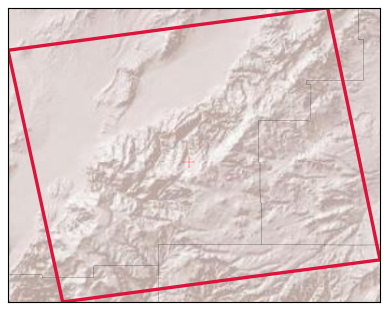

In [7]:
plt.figure(figsize=[6,6])
m.drawstates()
m.drawcounties()
m.arcgisimage(service='World_Shaded_Relief', dpi=500)
m.scatter(cLON, cLAT, marker='+', c='r', s=100, zorder=1000, latlon=True)

m.drawgreatcircle(lon[xy][0][0], lat[xy][0][0], lon[xy][0][-1], lat[xy][0][-1], c='crimson', lw=3)
m.drawgreatcircle(lon[xy][0][0], lat[xy][0][0], lon[xy][-1][0], lat[xy][-1][0], c='crimson', lw=3)
m.drawgreatcircle(lon[xy][-1][-1], lat[xy][-1][-1], lon[xy][-1][0], lat[xy][-1][0], c='crimson', lw=3)
m.drawgreatcircle(lon[xy][-1][-1], lat[xy][-1][-1], lon[xy][0][-1], lat[xy][0][-1], c='crimson', lw=3)


## Plot each hour for all months

In [8]:
# Dictionary for every hour, vector is value for each month.
hours = range(0,24)
months = range(1,13)
hour_data = {}

num_proc = np.minimum(multiprocessing.cpu_count(), len(months))

print 'Working on hour:',
for h in hours:
    print h,
    args = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
            (variable, month, 15, h), stat, xy, thresh] \
            for month in months]
    p = multiprocessing.Pool(num_proc)
    hour_data[h] = np.array(p.map(get_area_MP, args))
    p.close()

Working on hour: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23


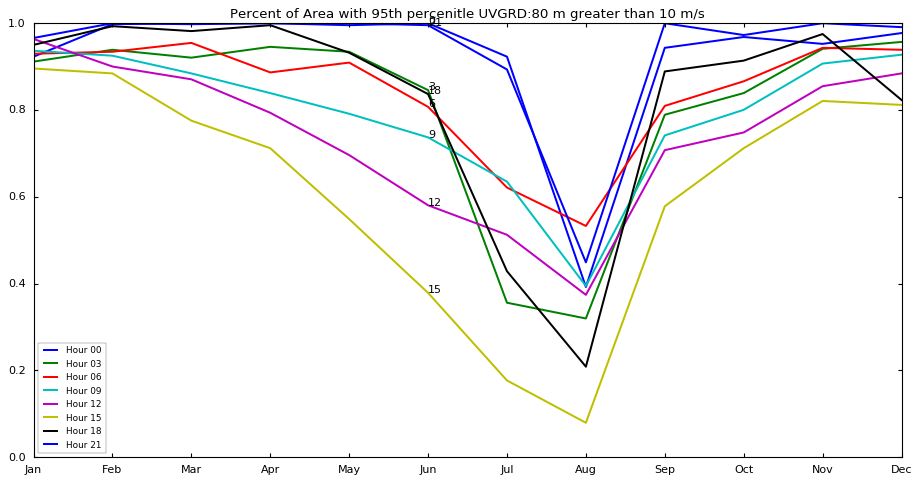

In [9]:
plt.figure(figsize=[14,7])
for i in hour_data.keys()[::3]:
    plt.plot(months, hour_data[i], label='Hour %02d' % i)
    plt.text(6, hour_data[i][5], i)
plt.legend(loc='best')

l = plt.xticks(months, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlim(1,12)

plt.title('Percent of Area with 95th percenitle %s greater than %s m/s' % (var, thresh))

## Plot each month for all hours

In [10]:
# Dictionary for every month, vector is value for each hour of day.
hours = range(0,24)
months = range(1,13)
month_data = {}

num_proc = np.minimum(multiprocessing.cpu_count(), len(hours))

print 'Working on month:',
for m in months:
    print m,
    args = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
            (variable, m, 15, hour), stat, xy, thresh] \
            for hour in hours]
    p = multiprocessing.Pool(num_proc)
    month_data[m] = np.array(p.map(get_area_MP, args))
    p.close()

Working on month: 1 2 3 4 5 6 7 8 9 10 11 12


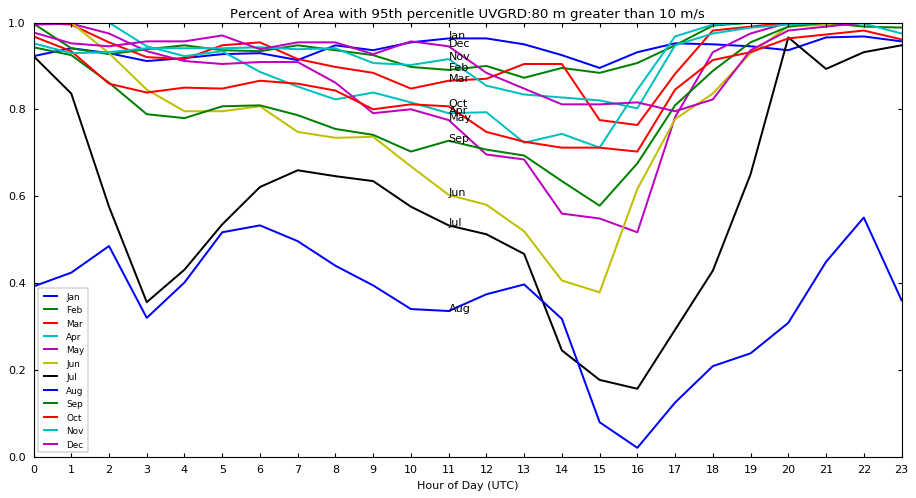

In [11]:
M = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=[14,7])
for i in month_data.keys()[::1]:
    plt.plot(hours, month_data[i], label=M[i-1])
    plt.text(11, month_data[i][11], M[i-1])
plt.legend(loc='best')

plt.xlim(0,23)
plt.xticks(range(0,24))
plt.xlabel('Hour of Day (UTC)')

plt.title('Percent of Area with 95th percenitle %s greater than %s m/s' % (var, thresh))

-----

# Percentile thresholds for given month and hour
Answers the question: At what percentile does the wind first exceed a threshold?  
- Darker colors = the wind threshold is more rare, becuase it is requires a 90th or 95th percentile to get that strong.  
- Lighter colors = the wind threshold is more common, becuase it only happens more than 10


In [12]:
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
m = draw_CONUS_HRRR_map()

M = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [13]:
# Percentile Variable and Statistic of interest
var = 'UVGRD:10 m'
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

month = 10
hour = 18

FILE = DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % (variable, month, 15, hour)
  
threshold = 5

percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]

# Make sure the percentiles are sorted and they are in desending order...
percentiles.sort()
percentiles.reverse()

# Initiate an array of 100 for maximum percentile, becuase every point
# will require at least the maximum percentile to reach the threshold.
# We will replace grids with other percentiles if one is found to 
# hit the threshold at an earlier percentile.
pdata = np.ones_like(lon)*100

for P in percentiles:
    # Temporaritlye store the percentile field
    ptemp = get_area(FILE, 'p%02d' % P)
    pdata[ptemp >= threshold] = P

# Need to sort percentiles back to ascending order
percentiles.sort()

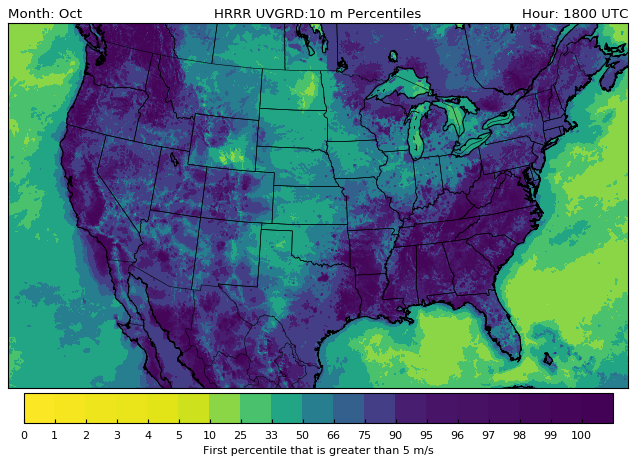

In [15]:
# Draw the Map
m.drawcoastlines(); m.drawstates(); m.drawcountries()
m.contourf(lon, lat, pdata, 
           levels=percentiles+[101],
           latlon=True,
           cmap='viridis_r')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95, ticks=percentiles)
cb.set_label('First percentile that is greater than %s m/s' % threshold)

plt.title('Month: %s' % (M[month-1]), loc='left')
plt.title('Hour: %s00 UTC' % (hour), loc='right')
plt.title('HRRR %s Percentiles' % var)

plt.savefig('./figs/CONUS_percentiles_thresh_m%02d_h%02d' % (month, hour))

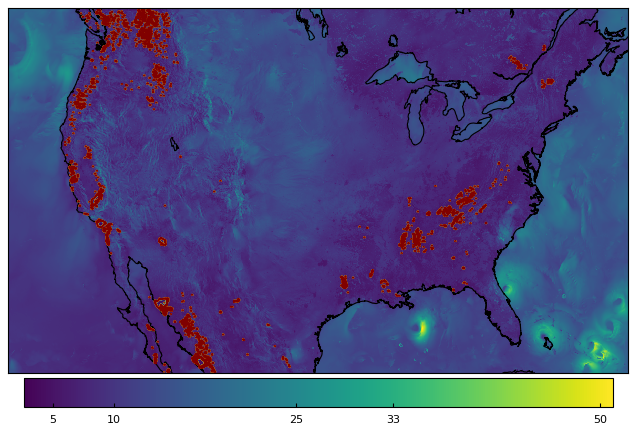

In [19]:
test = 100
test = get_area(FILE, 'p%02d' % test)
threshold = 5

m.drawcoastlines()

m.pcolormesh(lon, lat, test, latlon=True, cmap='viridis')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95, ticks=[0,5,10,25,33,50,66,75,90,95,100])

m.contour(lon, lat, test>threshold,
           latlon=True)


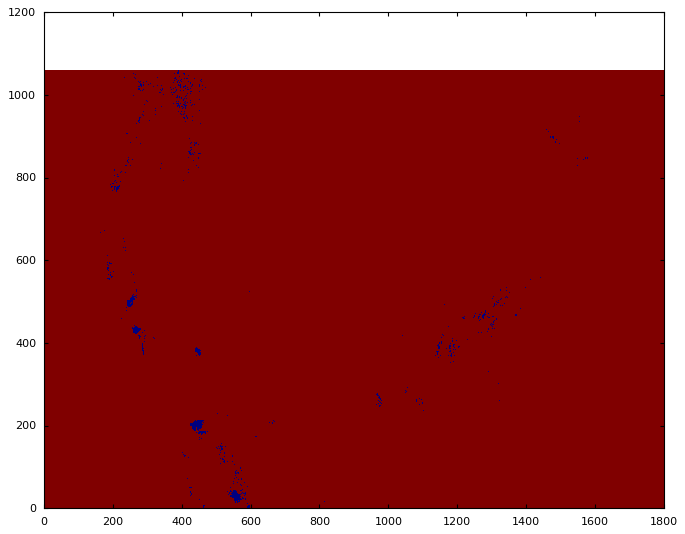

In [20]:
plt.pcolormesh(test>5)

### For a smaller domain

In [21]:
FIRES = {'PIONEER':{'lat': 43.950,
                    'lon': -115.762,
                    'start': datetime(2016, 7, 18),
                    'state': 'Idaho'},         
         'BRIANHEAD':{'lat': 37.718,
                      'lon': -112.837,
                      'start': datetime(2017, 6, 17),
                      'state': 'Utah'},
         'SOUTHERN LNU COMPLEX':{'lat': 38.296,
                                 'lon': -122.275,
                                 'start': datetime(2017, 10, 9),
                                 'state': 'California'},
         'CENTRAL LNU COMPLEX':{'lat': 38.433,
                                'lon': -122.703,
                                'start': datetime(2017, 10, 9),
                                'state': 'California'},
         'THOMAS':{'lat': 34.429,
                   'lon': -119.100,
                   'start': datetime(2017, 12, 5),
                   'satet': 'California'},
         'CREEK':{'lat': 34.334,
                  'lon': -118.338,
                  'start': datetime(2017, 12, 5),
                  'state': 'California'},
         'RYE':{'lat': 34.453,
                'lon': -118.581,
                'start': datetime(2017, 12, 5),
                'state': 'California'},
         }

In [24]:
# Domain center and area
FIRE = 'RYE'
cLAT = FIRES[FIRE]['lat']
cLON = FIRES[FIRE]['lon']

# Plot a map of the area of interest
bot_left_lat  = cLAT - .8
bot_left_lon  = cLON - 1
top_right_lat = cLAT + .8
top_right_lon = cLON + 1

m2 = Basemap(resolution='i', projection='cyl', area_thresh=1500,\
        llcrnrlon=bot_left_lon, llcrnrlat=bot_left_lat, \
        urcrnrlon=top_right_lon, urcrnrlat=top_right_lat)

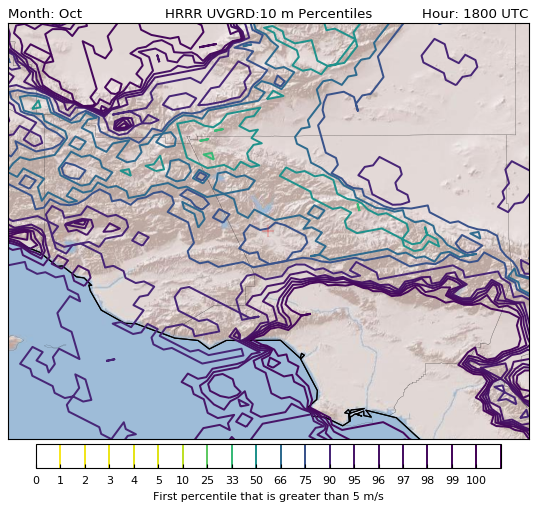

In [25]:
m2.drawcoastlines(); m2.drawcounties(); m2.drawstates()
m2.arcgisimage(service='World_Shaded_Relief', xpixels=800, verbose=False)

# Draw the Map
m2.drawcoastlines(); m2.drawstates(); m2.drawcountries()
m2.contour(lon, lat, pdata, 
           levels=percentiles+[101],
           latlon=True,
           cmap='viridis_r')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.75, ticks=percentiles)
cb.set_label('First percentile that is greater than %s m/s' % threshold)

m2.scatter(cLON, cLAT, marker='+', c='r', s=100, zorder=1000, latlon=True)

plt.title('Month: %s' % (M[month-1]), loc='left')
plt.title('Hour: %s00 UTC' % (hour), loc='right')
plt.title('HRRR %s Percentiles' % var)

plt.savefig('./figs/%s_percentiles_thresh_m%02d_h%02d' % (FIRE, month, hour))